<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# AI in Finance

**Workshop at Texas State University (October 2023)**

**_Simulating Financial Time Series Data_**

Dr. Yves J. Hilpisch | The Python Quants GmbH | http://tpq.io

## Generated Data

## Simple GAN

In [1]:
import numpy as np
import pandas as pd
from pylab import plt, mpl

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

In [3]:
plt.style.use('seaborn-v0_8')
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

In [4]:
x = np.linspace(-2, 2, 500)

In [5]:
def f(x):
    return x ** 3

In [6]:
y = f(x)

In [7]:
scaler = StandardScaler()

In [8]:
y_ = scaler.fit_transform(y.reshape(-1, 1))

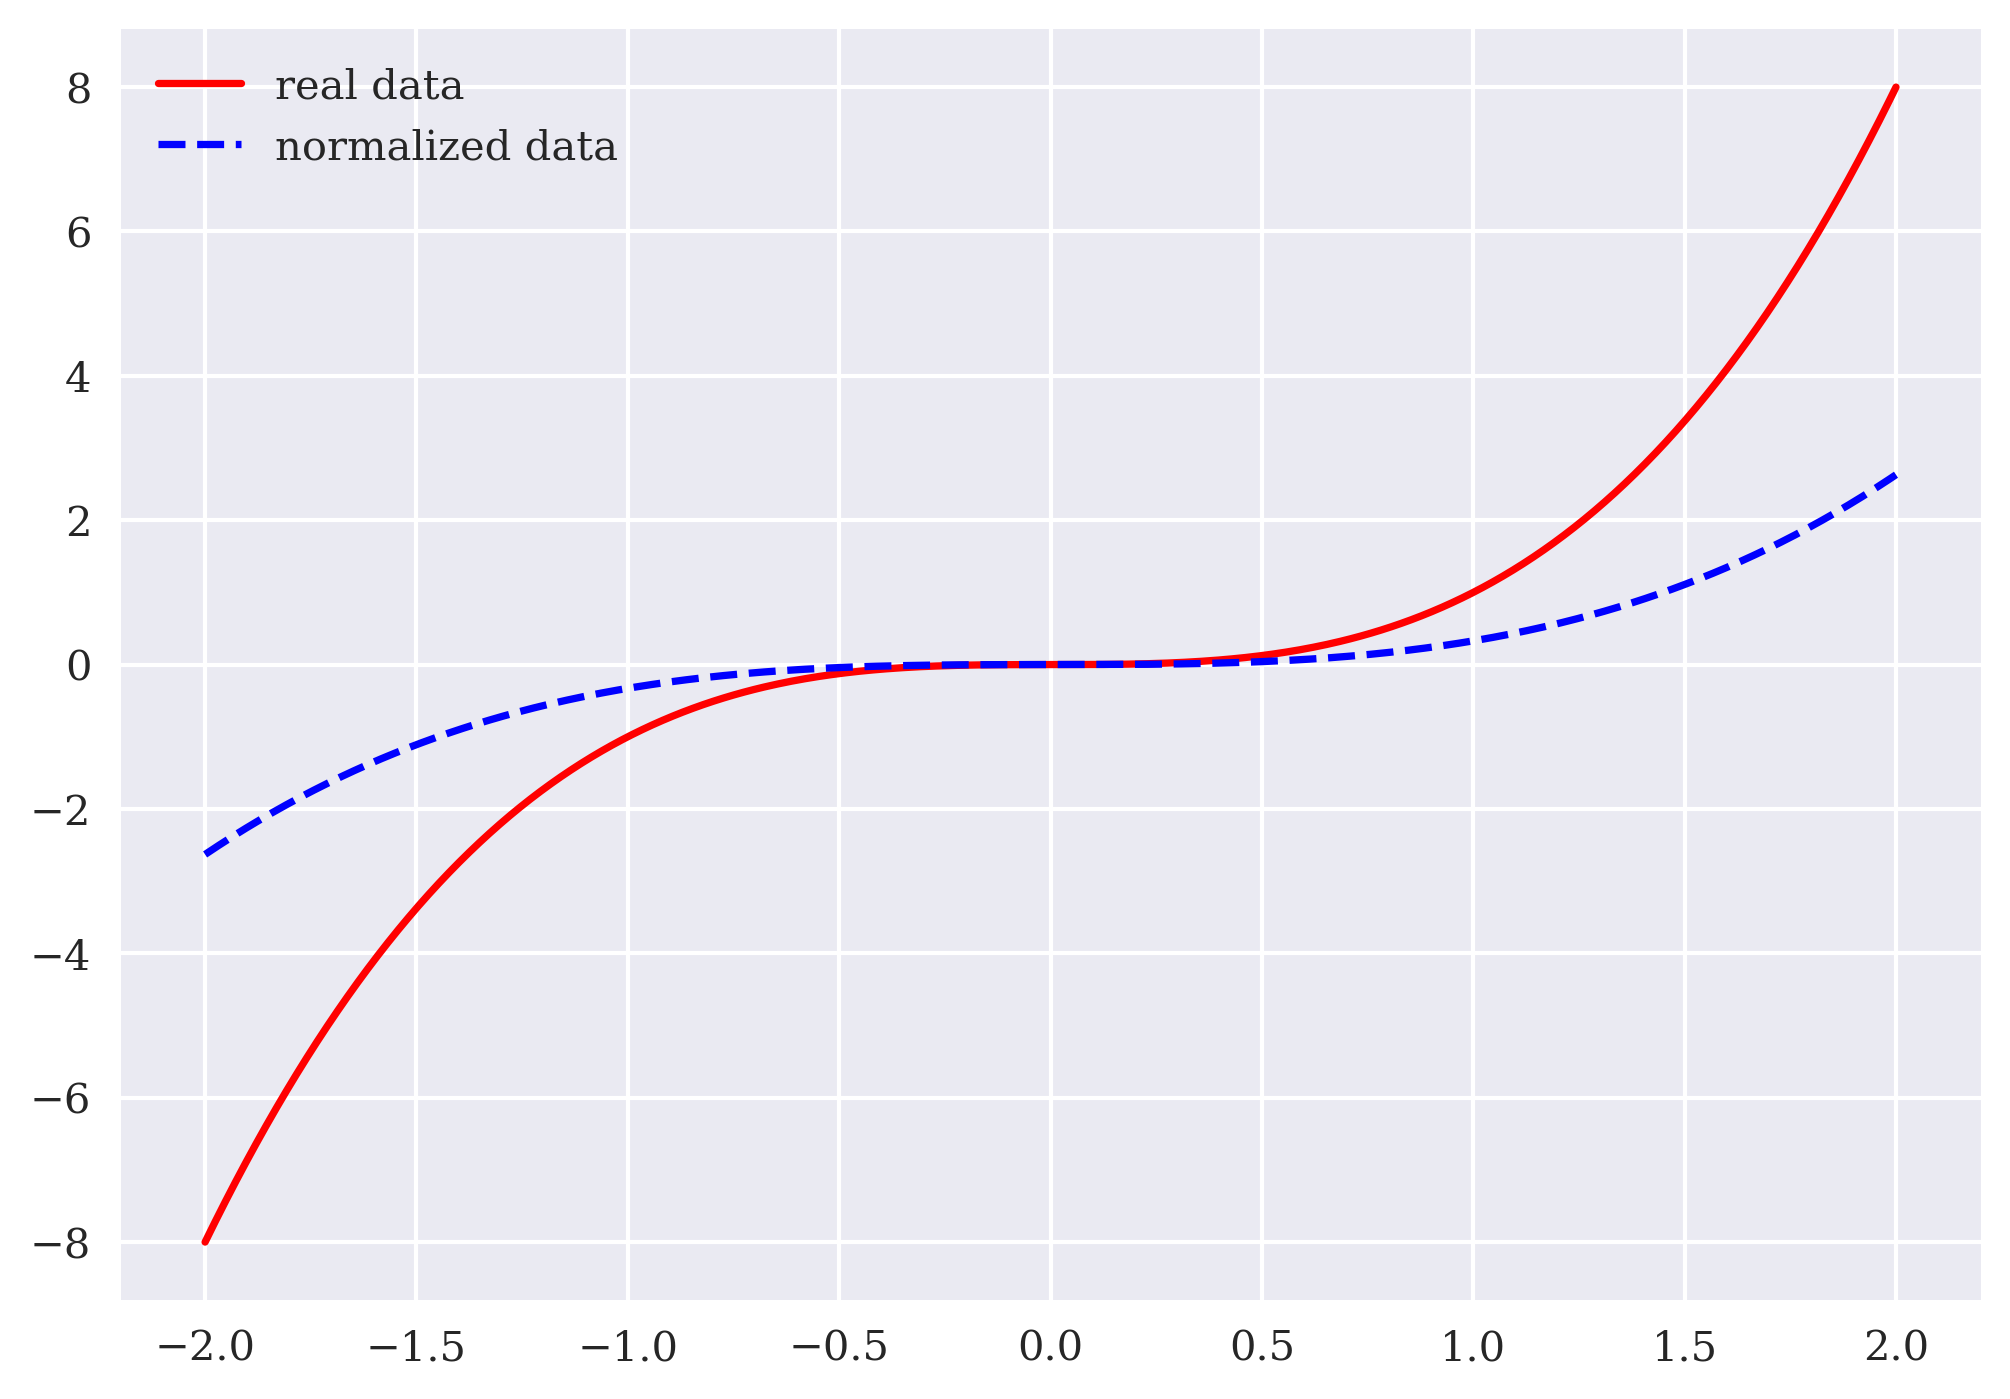

In [9]:
plt.plot(x, y, 'r', label='real data')
plt.plot(x, y_, 'b--', label='normalized data')
plt.legend();

### Model Training

In [10]:
def create_generator(hu=32):
    model = Sequential()
    model.add(Dense(hu, activation='relu', input_dim=1))
    model.add(Dense(hu, activation='relu'))
    model.add(Dense(1, activation='linear'))
    return model

In [11]:
def create_discriminator(hu=32):
    model = Sequential()
    model.add(Dense(hu, activation='relu', input_dim=1))
    model.add(Dense(hu, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(),
                  metrics=['accuracy'])
    return model

In [12]:
def create_gan(generator, discriminator, lr=0.001):
    discriminator.trainable = False  # weights are kept fix
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=lr))
    return model

generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(generator, discriminator, 0.0005)

In [13]:
from numpy.random import default_rng

In [14]:
rng = default_rng()

In [15]:
def train_models(y_, epochs, batch_size):
    for epoch in range(epochs):
        # Generate synthetic data
        noise = rng.normal(0, 1, (batch_size, 1))
        synthetic_data = generator.predict(noise, verbose=False)

        # Train discriminator
        real_data = y_[rng.integers(0, len(y_), batch_size)]
        discriminator.train_on_batch(real_data, np.ones(batch_size))
        discriminator.train_on_batch(synthetic_data,
                                     np.zeros(batch_size))

        # Train generator
        noise = rng.normal(0, 1, (batch_size, 1))
        gan.train_on_batch(noise, np.ones(batch_size))

        # Print progress
        if epoch % 1000 == 0:
            print(f'Epoch: {epoch}')
    return real_data, synthetic_data

In [16]:
%%time
real_data, synthetic_data = train_models(
    y_=y_, epochs=1001, batch_size=32)

2023-10-28 11:30:16.733928: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch: 0
Epoch: 1000
CPU times: user 25.4 s, sys: 2.71 s, total: 28.2 s
Wall time: 25.9 s


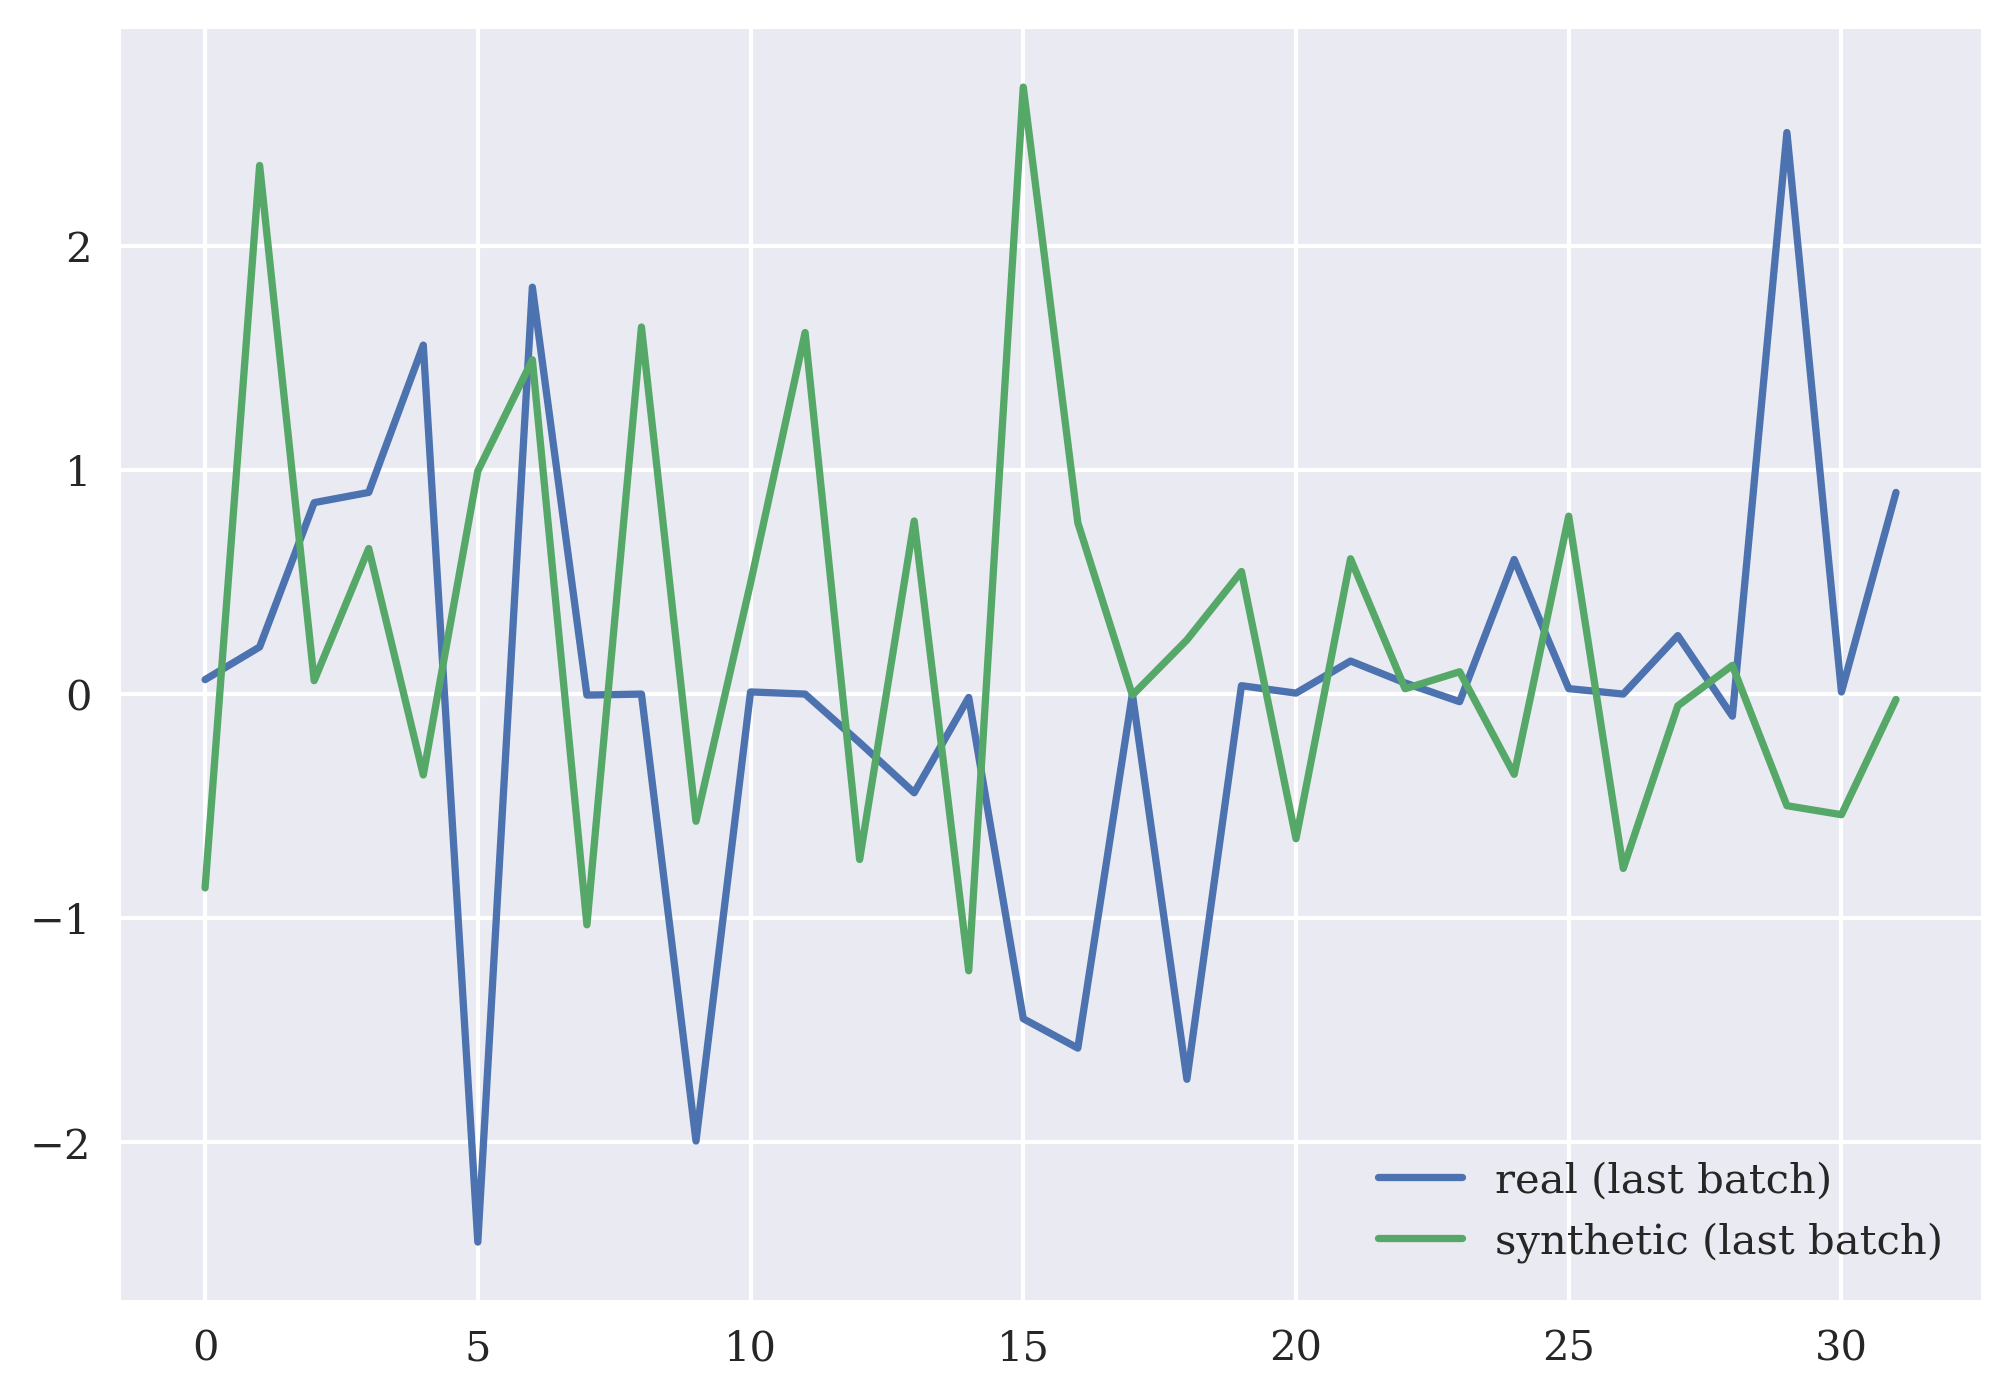

In [17]:
plt.plot(real_data, label='real (last batch)')
plt.plot(synthetic_data, label='synthetic (last batch)')
plt.legend();

In [18]:
data = pd.DataFrame({'real': y}, index=x)

In [19]:
N = 5
for i in range(N):
    noise = rng.normal(0, 1, (len(y), 1))
    synthetic_data = generator.predict(noise, verbose=False)
    data[f'synth_{i:02d}'] = scaler.inverse_transform(synthetic_data)

In [20]:
data.describe().round(3)

,real,synth_00,synth_01,synth_02,synth_03,synth_04
count,500.000,500.000,500.000,500.000,500.000,500.000
mean,-0.000,0.213,0.423,0.542,0.387,0.128
std,3.045,2.825,2.817,2.978,3.003,2.798
min,-8.000,-7.365,-9.608,-6.290,-7.443,-8.064
25%,-1.000,-1.567,-1.310,-1.255,-1.563,-1.412
50%,-0.000,0.001,0.089,0.077,-0.005,-0.120
75%,1.000,1.709,1.916,2.237,2.140,1.231
max,8.000,8.739,9.801,10.456,12.556,11.529


In [21]:
((data.apply(np.sort)['real'] -
  data.apply(np.sort)['synth_00']) ** 2).mean()

0.46551295548780786

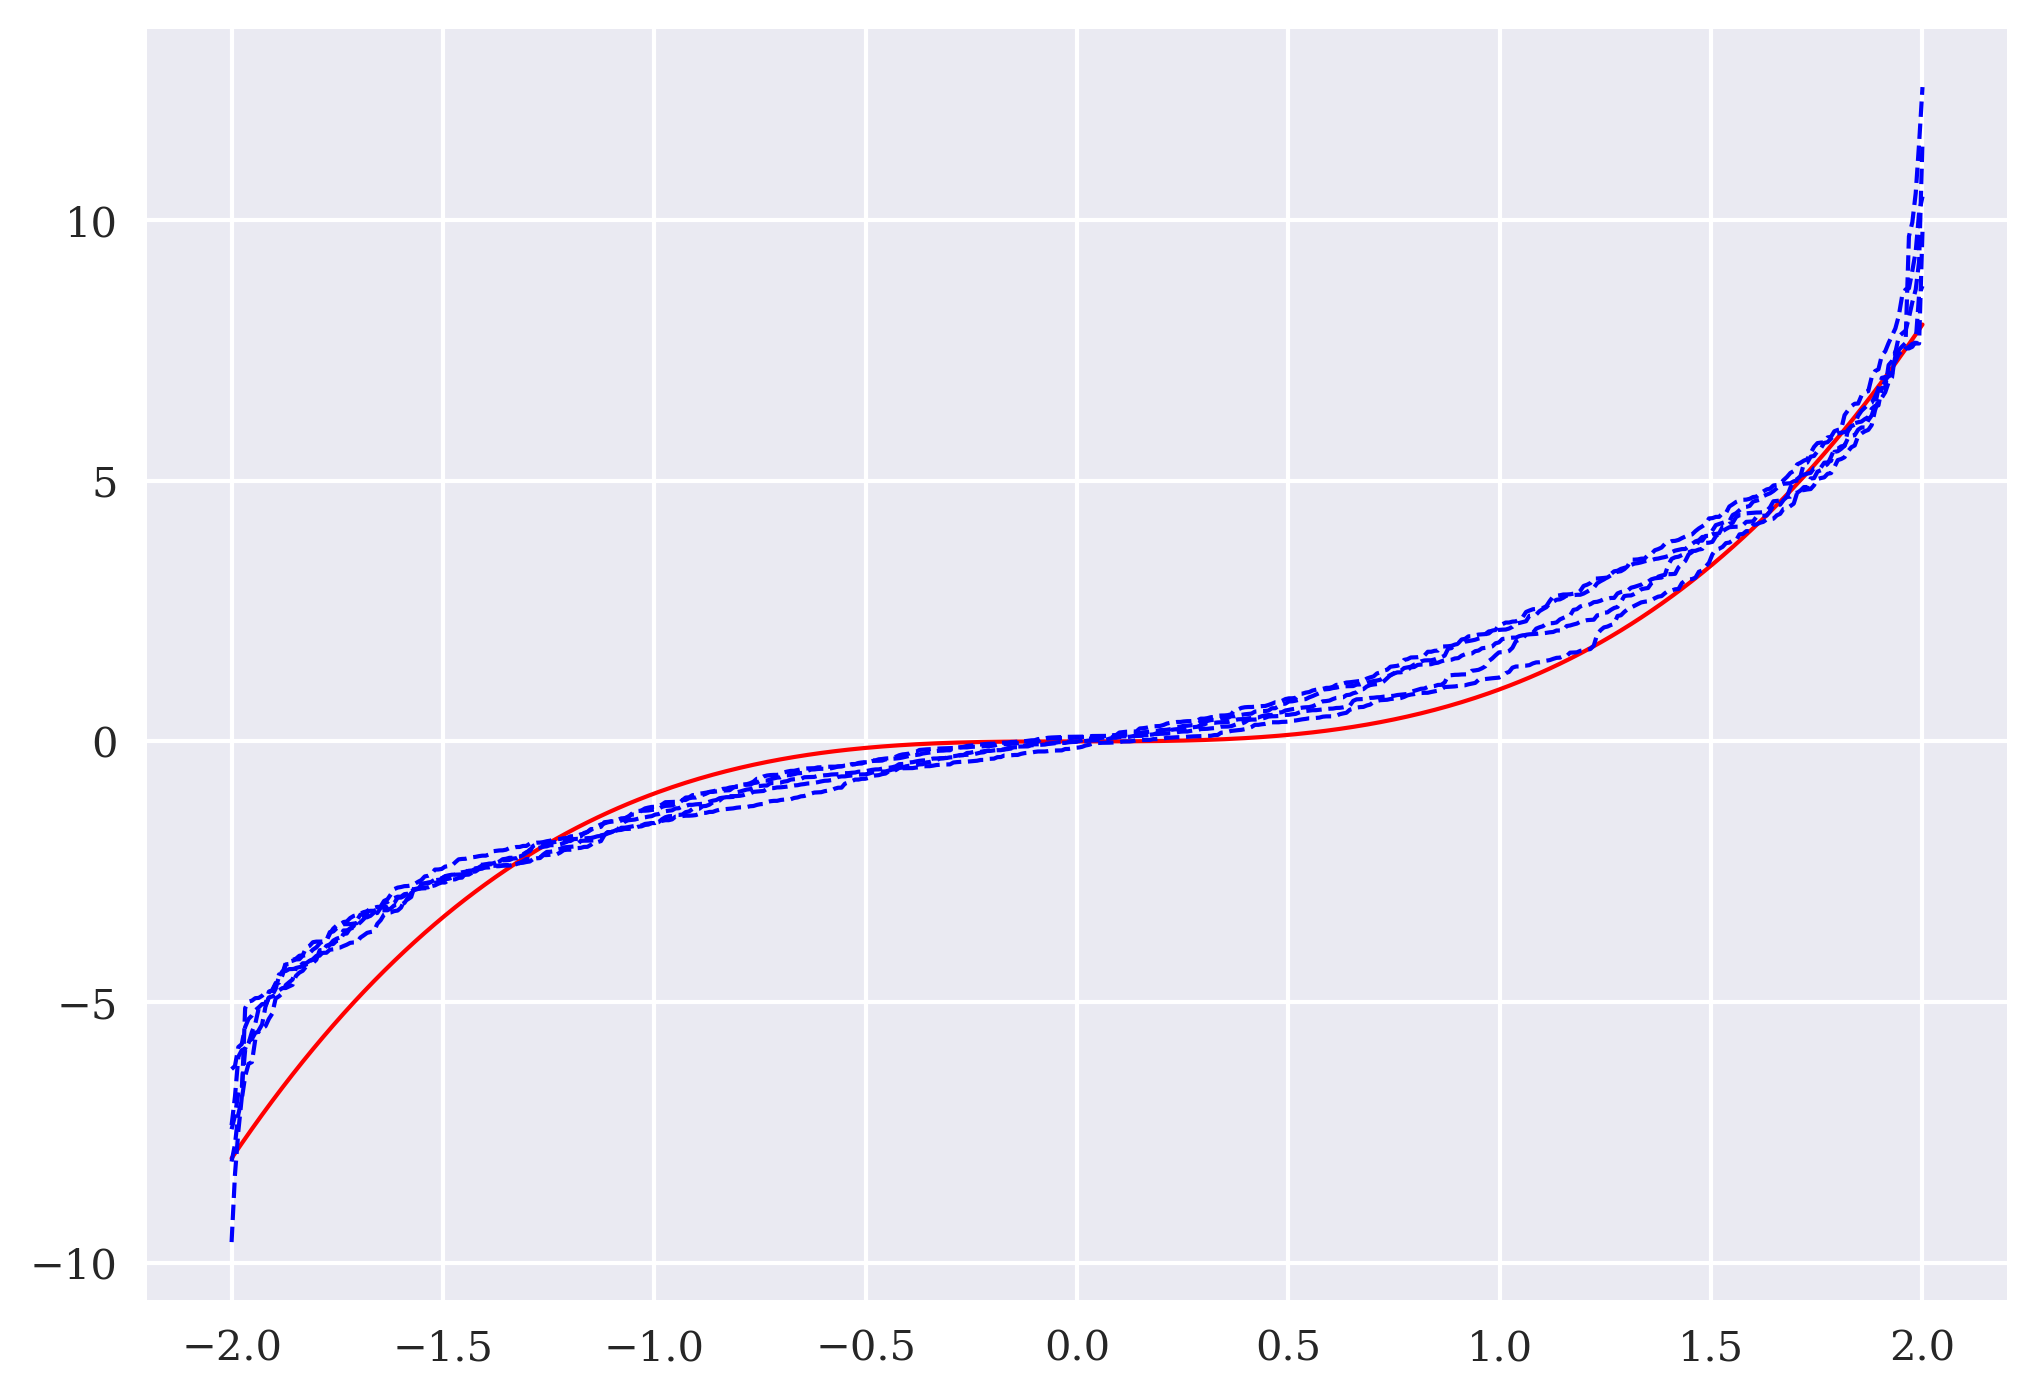

In [22]:
data.apply(np.sort).plot(style=['r'] + N * ['b--'], lw=1, legend=False);

## Financial Example

In [23]:
raw = pd.read_csv('https://certificate.tpq.io/eod_prices.csv',
                 index_col=0, parse_dates=True).dropna()

In [24]:
rets = raw['AAPL'].iloc[-1000:]
rets = np.log((rets / rets.shift(1)).dropna())
rets = rets.values

In [25]:
scaler = StandardScaler()

In [26]:
rets_ = scaler.fit_transform(rets.reshape(-1, 1))

In [27]:
generator = create_generator(hu=32)
discriminator = create_discriminator(hu=32)
gan = create_gan(generator, discriminator, lr=0.001)

In [28]:
def train_models(epochs, batch_size):
    for epoch in range(epochs):
        # Generate synthetic data
        noise = rng.normal(0, 1, (batch_size, 1))
        synthetic_data = generator.predict(noise, verbose=False)

        # Train discriminator
        real_data =rets_[rng.integers(0, len(rets_), batch_size)]
        discriminator.train_on_batch(real_data, np.ones(batch_size))
        discriminator.train_on_batch(synthetic_data,
                                     np.zeros(batch_size))

        # Train generator
        noise = rng.normal(0, 1, (batch_size, 1))
        gan.train_on_batch(noise, np.ones(batch_size))

        # Print progress
        if epoch % 1000 == 0:
            print(f'Epoch: {epoch}')
    return real_data, synthetic_data

In [29]:
%time rd, sd = train_models(epochs=5001, batch_size=32)

Epoch: 0
Epoch: 1000
Epoch: 2000
Epoch: 3000
Epoch: 4000
Epoch: 5000
CPU times: user 2min 5s, sys: 13.1 s, total: 2min 18s
Wall time: 2min 7s


In [30]:
data = pd.DataFrame({'real': rets})

In [31]:
N = 10

In [47]:
for i in range(N):
    noise = np.random.normal(0, 1, (len(rets_), 1))
    sd = generator.predict(noise, verbose=False)
    synthetic_data = sd # (sd - sd.mean()) / sd.std()
    data[f'synth_{i:02d}'] = scaler.inverse_transform(synthetic_data)

In [48]:
res = data.describe().round(4)
res.iloc[:, :5]

,real,synth_00,synth_01,synth_02,synth_03
count,999.0000,999.0000,999.0000,999.0000,999.0000
mean,0.0010,0.0015,0.0023,0.0015,0.0008
std,0.0212,0.0147,0.0146,0.0154,0.0149
min,-0.1377,-0.0558,-0.0525,-0.0505,-0.0554
25%,-0.0093,-0.0076,-0.0061,-0.0084,-0.0085
50%,0.0011,0.0047,0.0053,0.0053,0.0045
75%,0.0129,0.0114,0.0120,0.0116,0.0112
max,0.1132,0.0452,0.0529,0.0490,0.0532


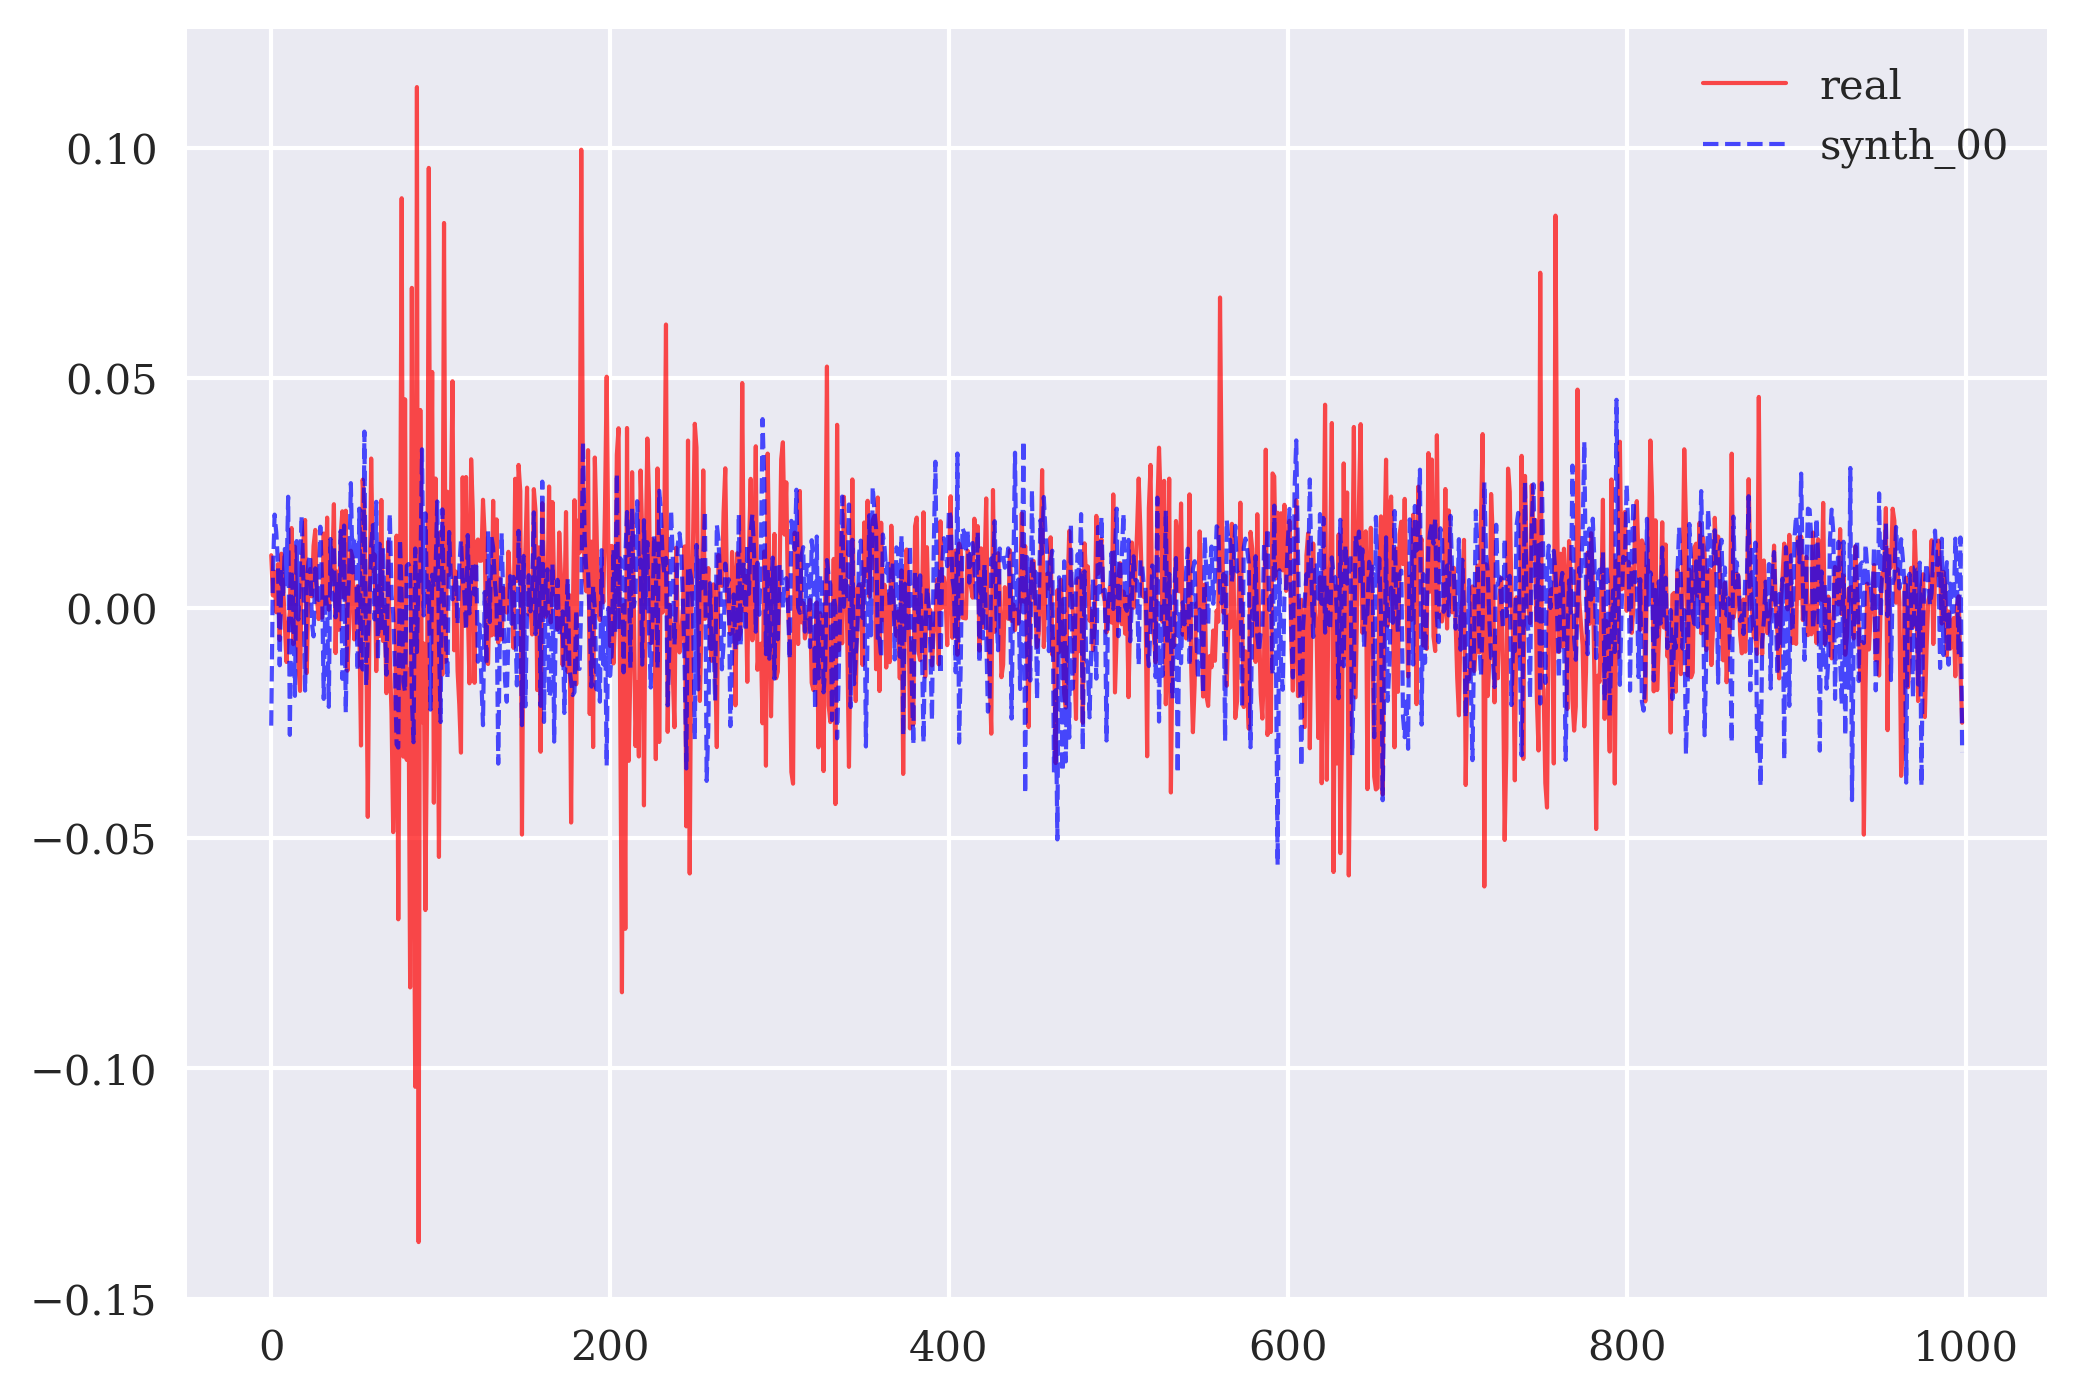

In [49]:
data.iloc[:, :2].plot(style=['r', 'b--', 'b--'], lw=1, alpha=0.7);

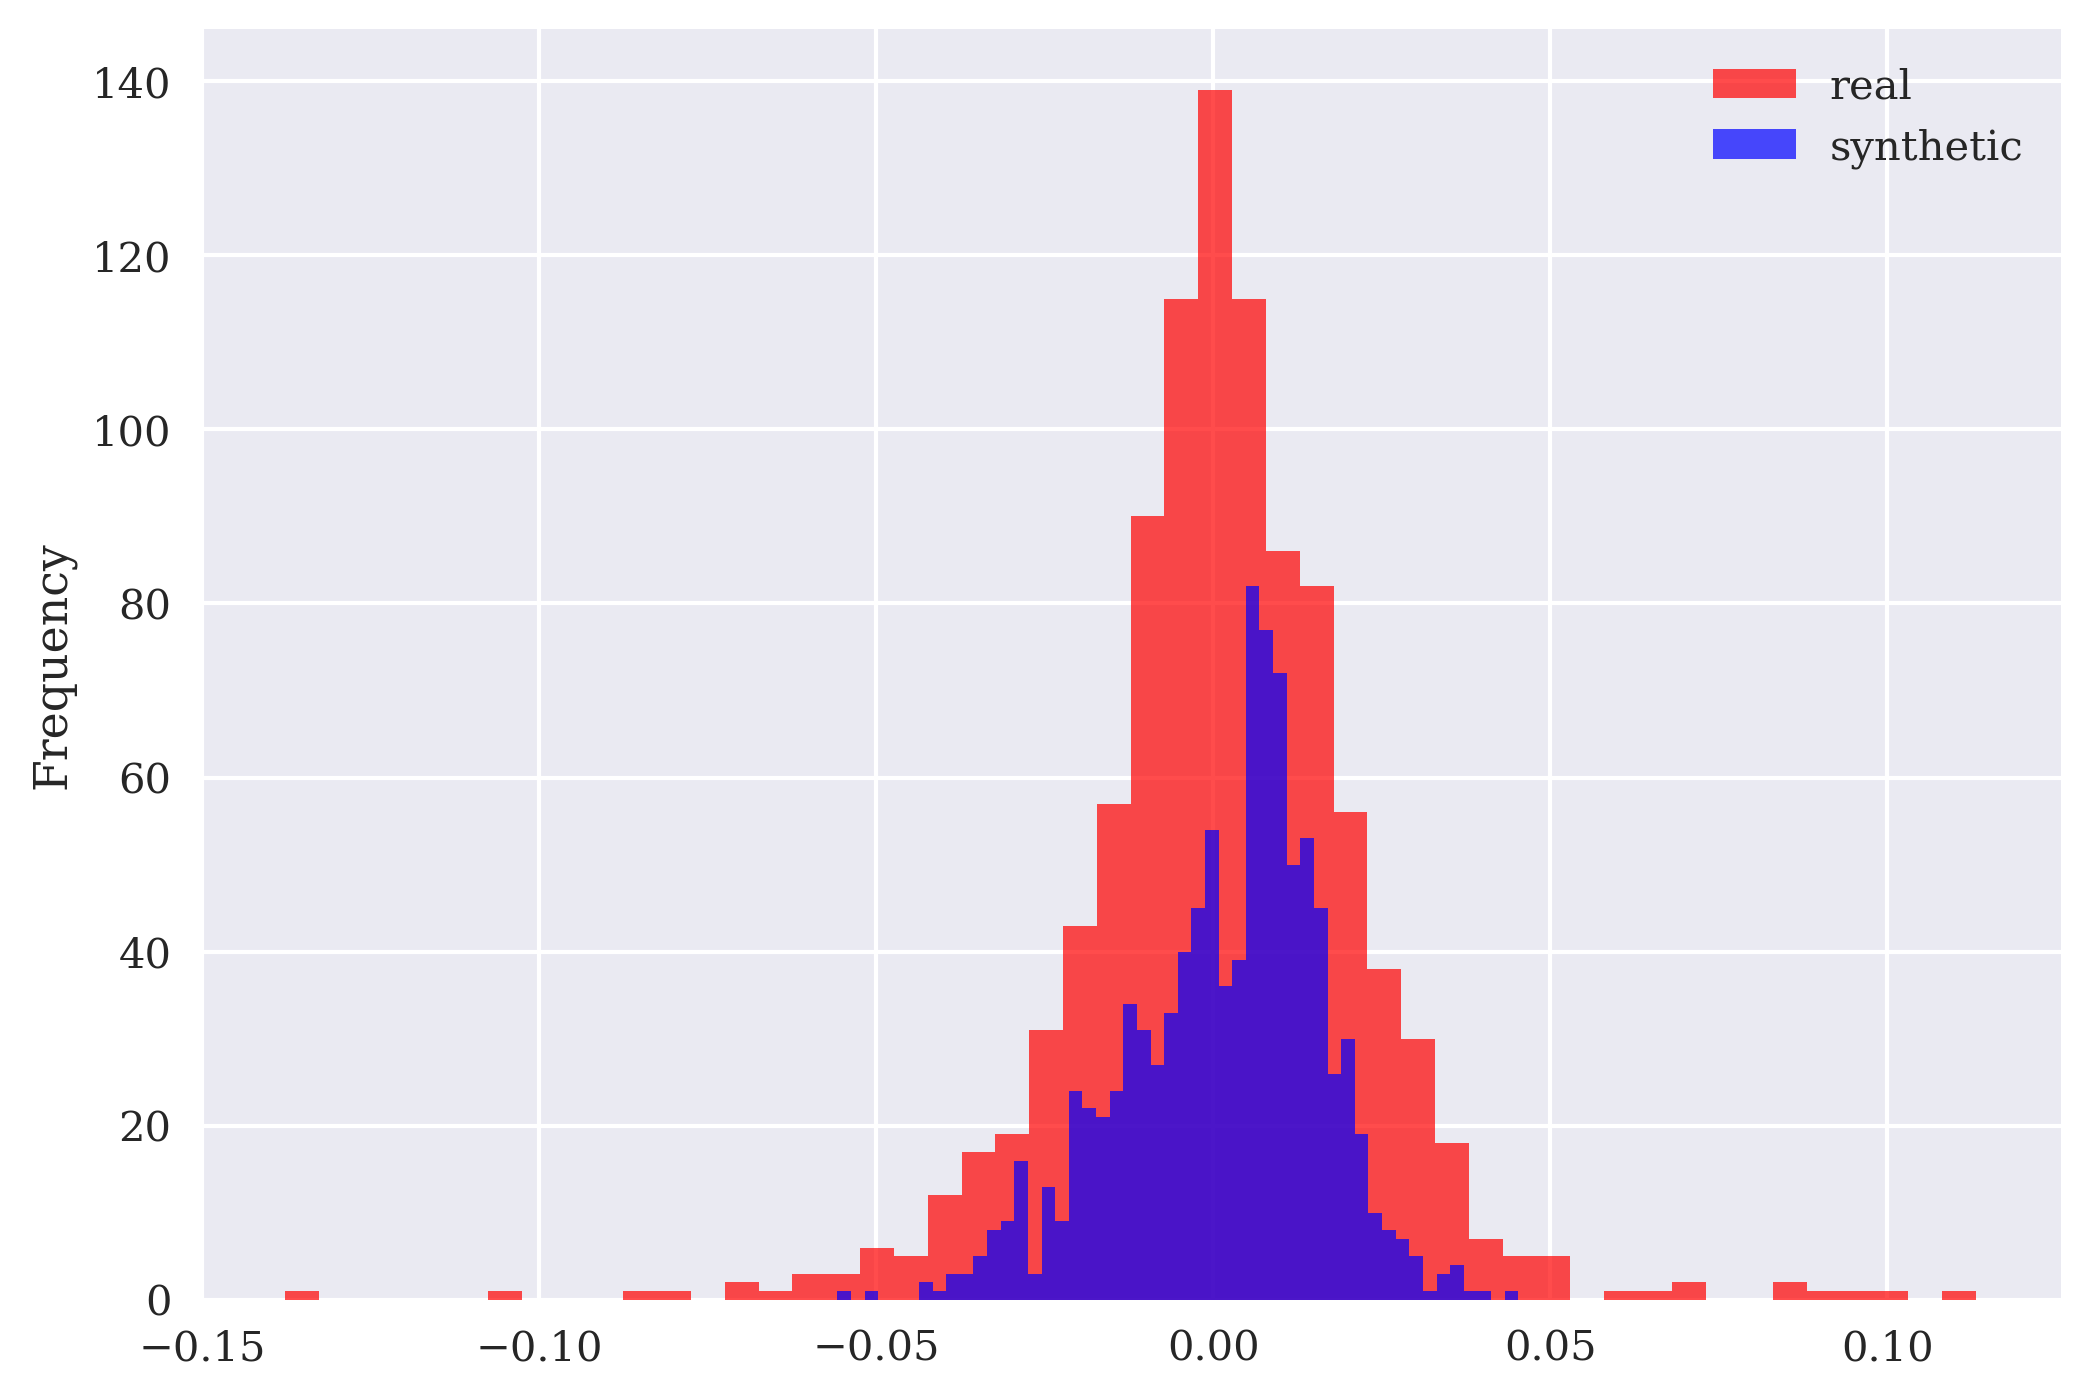

In [50]:
data['real'].plot(kind='hist', bins=50, label='real',
                  color='r', alpha=0.7)
data['synth_00'].plot(kind='hist', bins=50, alpha=0.7,
                  label='synthetic', color='b', sharex=True)
plt.legend();

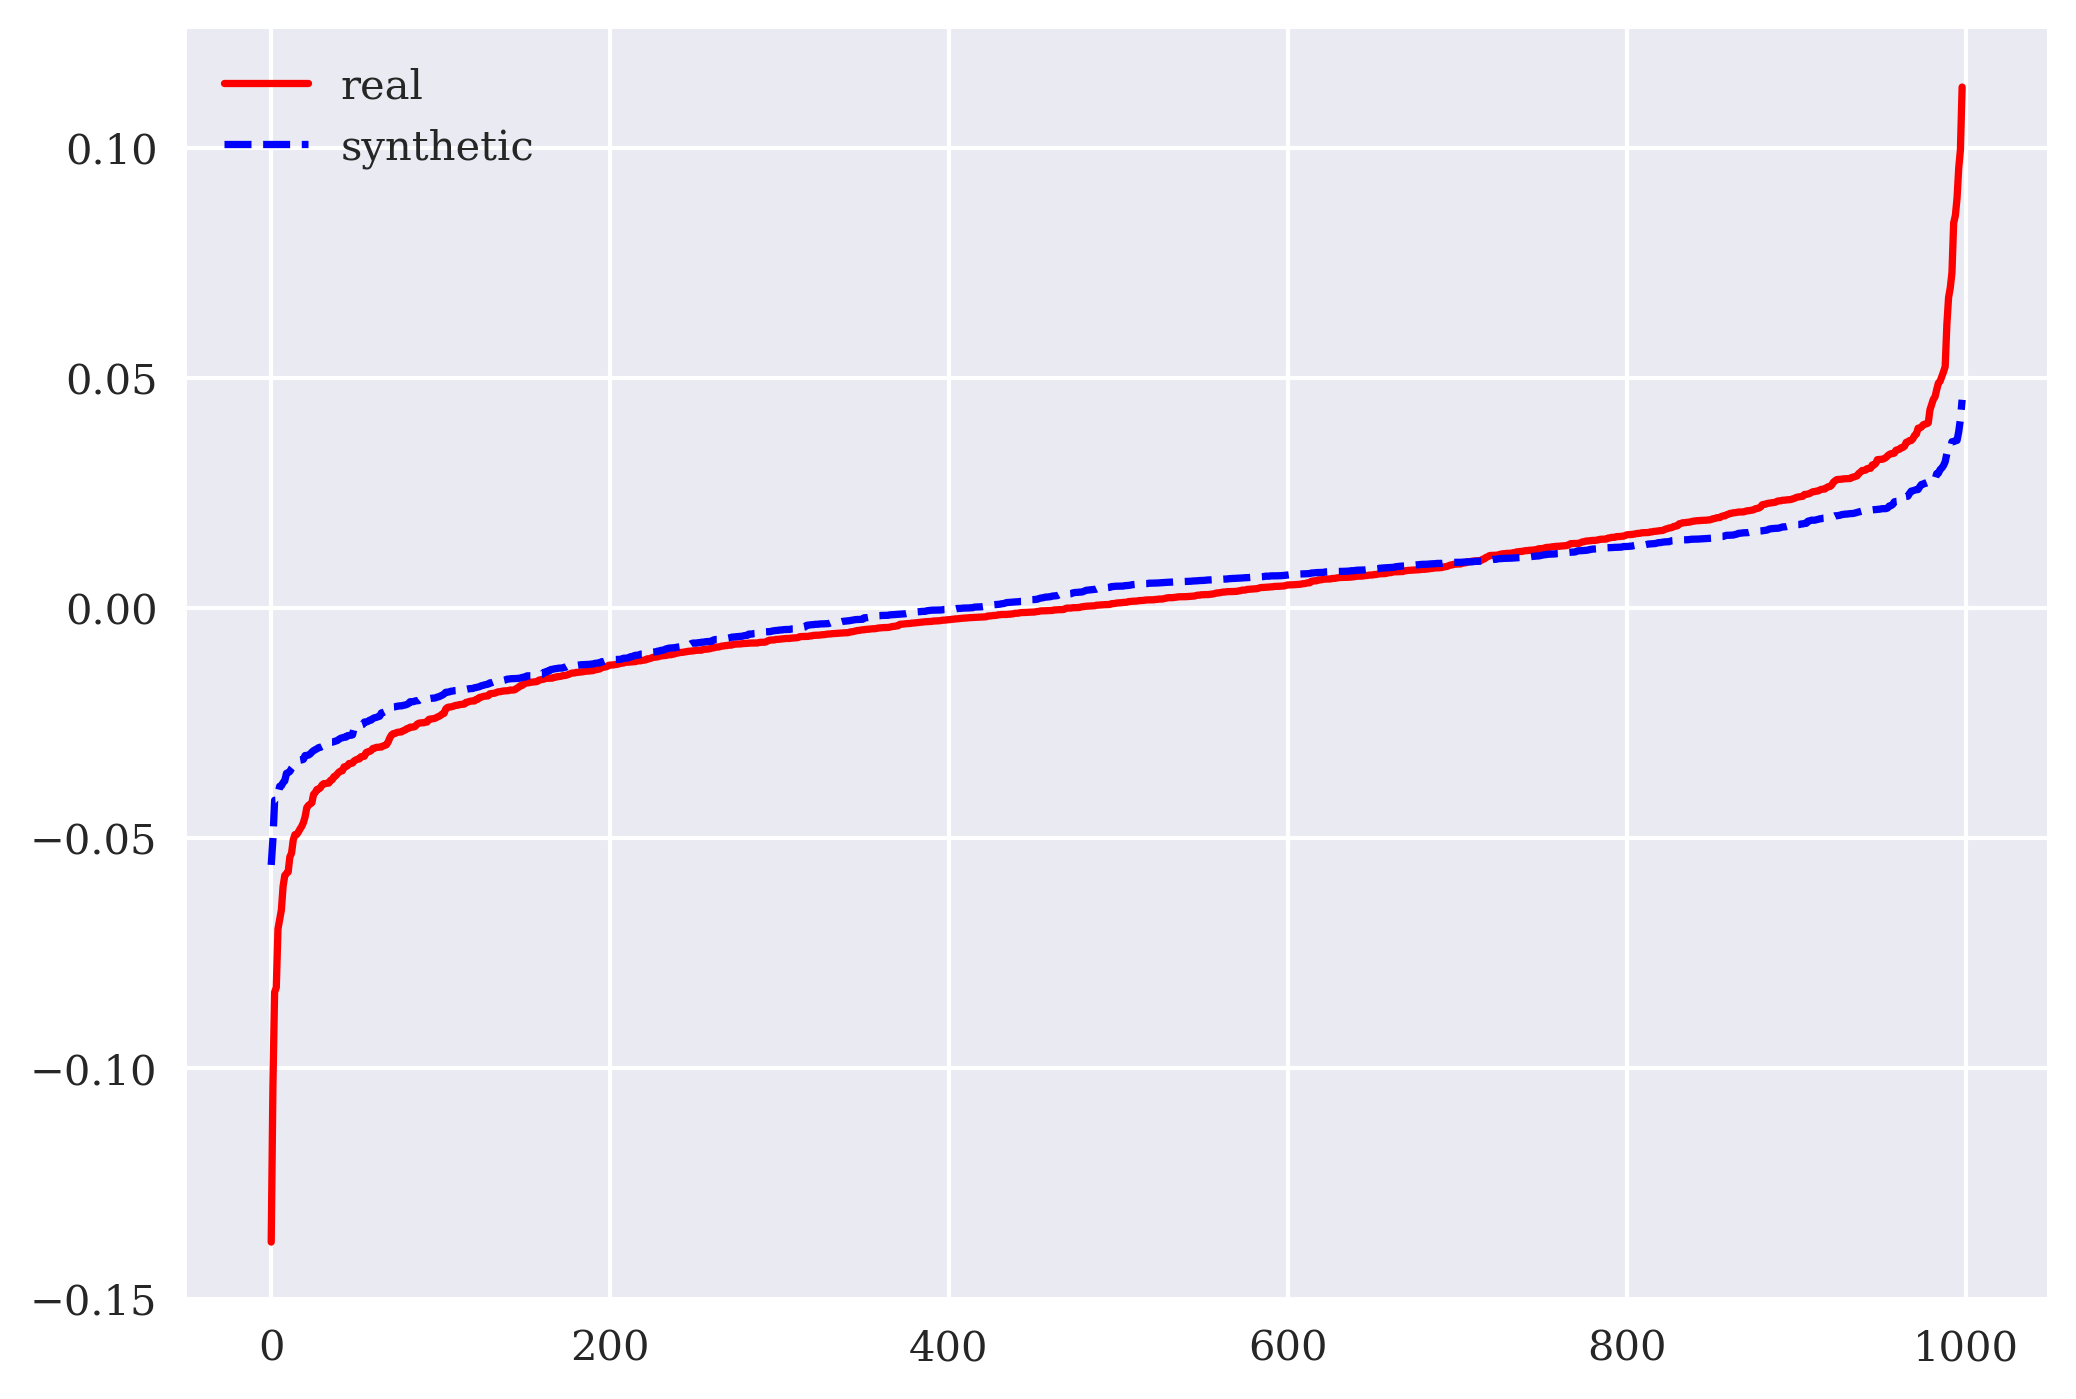

In [51]:
plt.plot(np.sort(data['real']), 'r', label='real')
plt.plot(np.sort(data['synth_00']), 'b--', label='synthetic')
plt.legend();

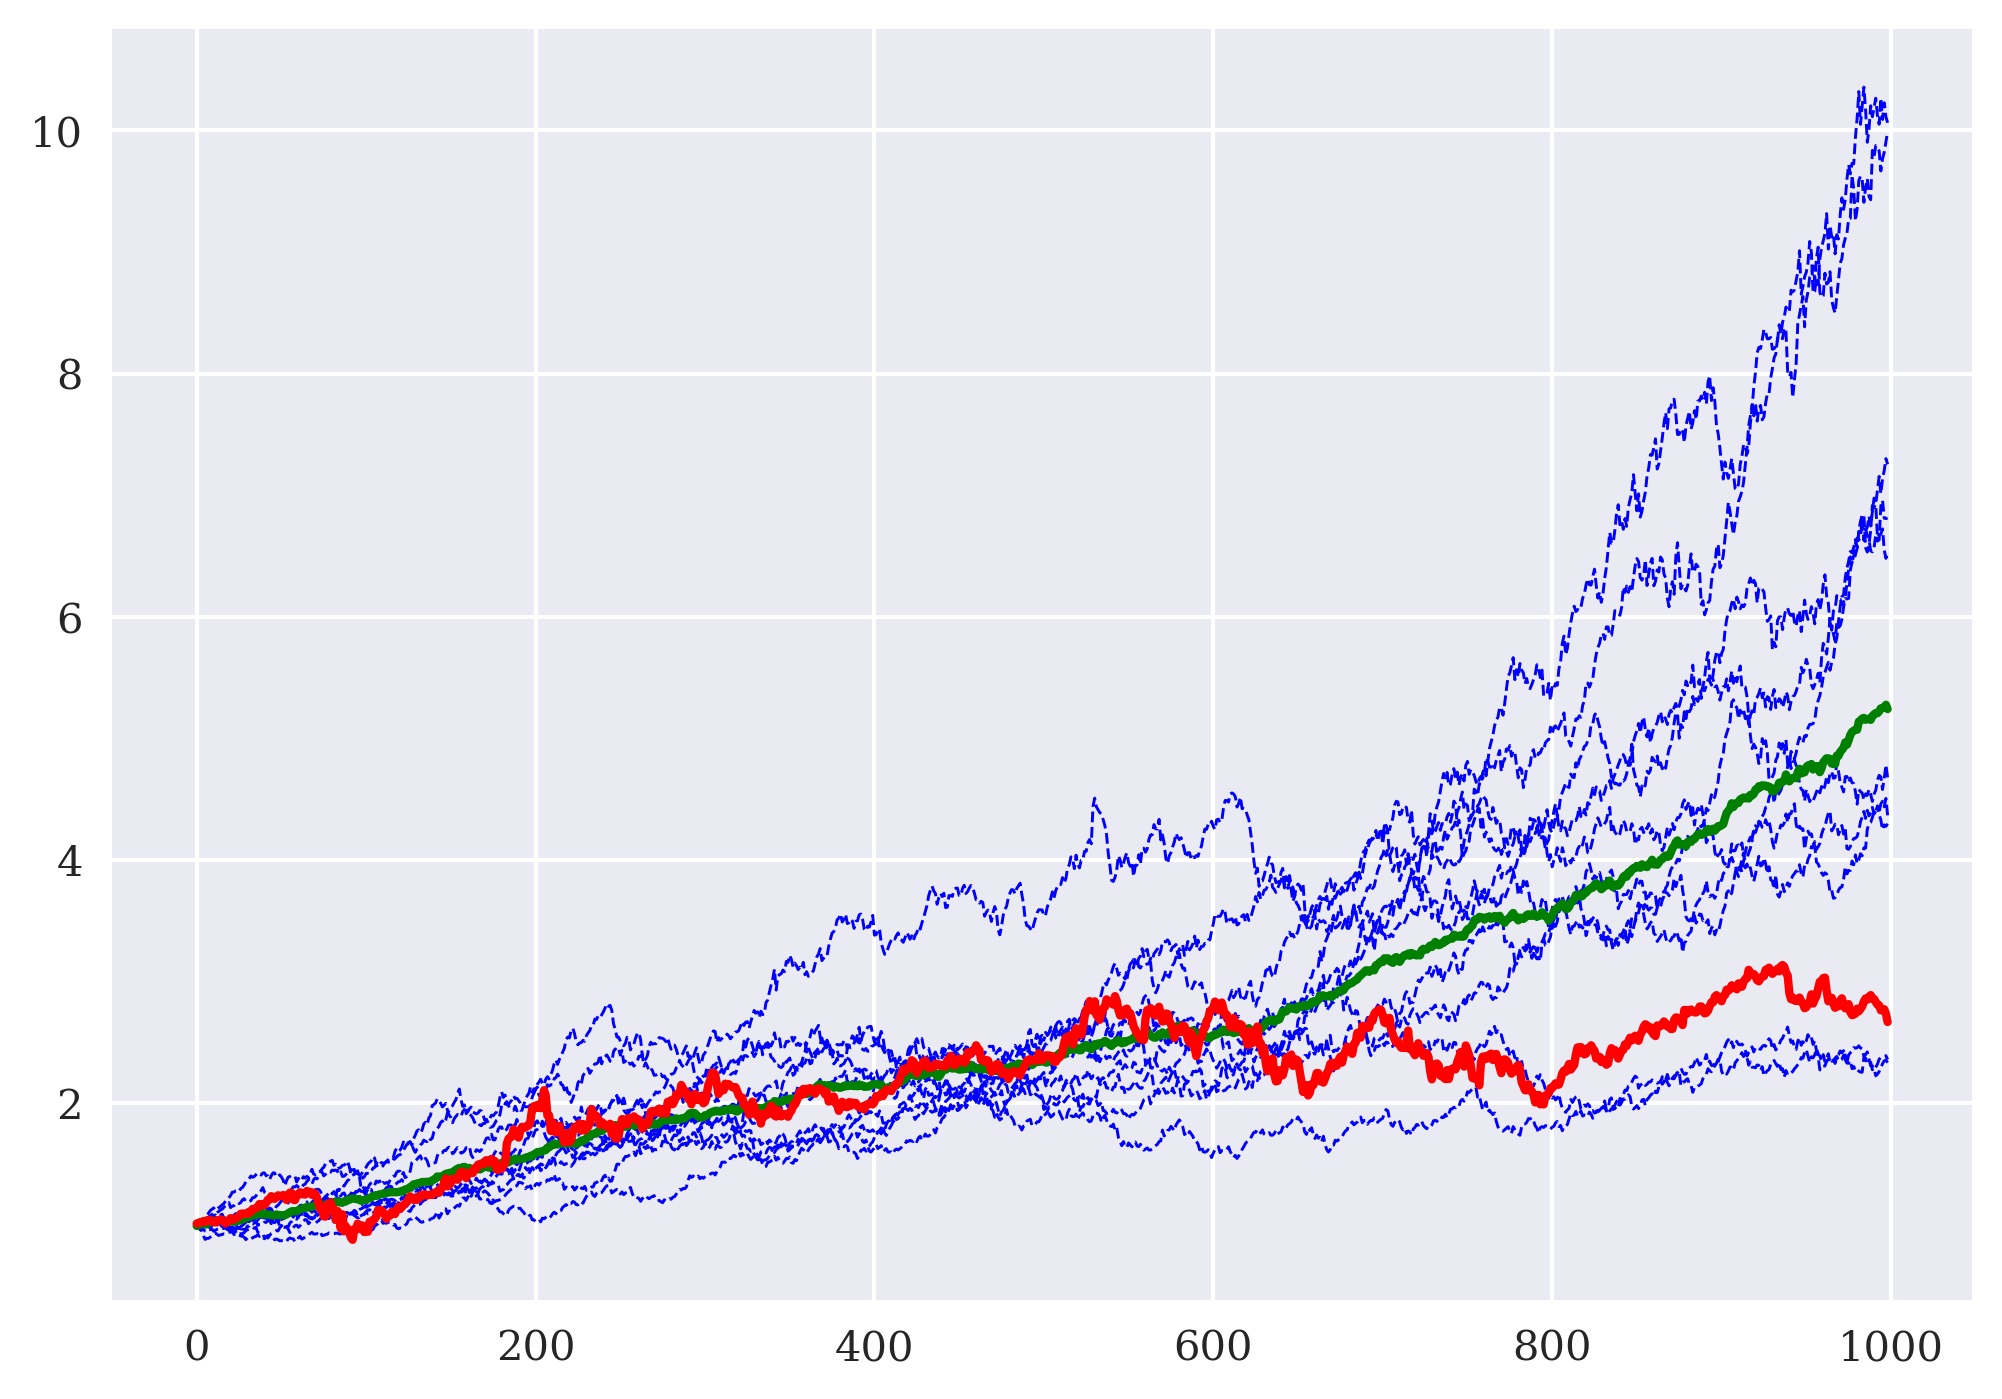

In [52]:
sn = N
data.iloc[:, 1:sn + 1].cumsum().apply(np.exp).plot(
    style='b--', lw=0.7, legend=False)
data.iloc[:, 1:sn + 1].mean(axis=1).cumsum().apply(
    np.exp).plot(style='g', lw=2)
data['real'].cumsum().apply(np.exp).plot(style='r', lw=2);

## Moving Forward

In [53]:
future = pd.DataFrame({'real': len(data) * [np.nan]})

In [54]:
for i in range(N):
    noise = np.random.normal(0, 1, (len(rets_), 1))
    sd = generator.predict(noise, verbose=False)
    synthetic_data = (sd - sd.mean()) / sd.std()
    future[f'synth_{i:02d}'] = scaler.inverse_transform(synthetic_data)

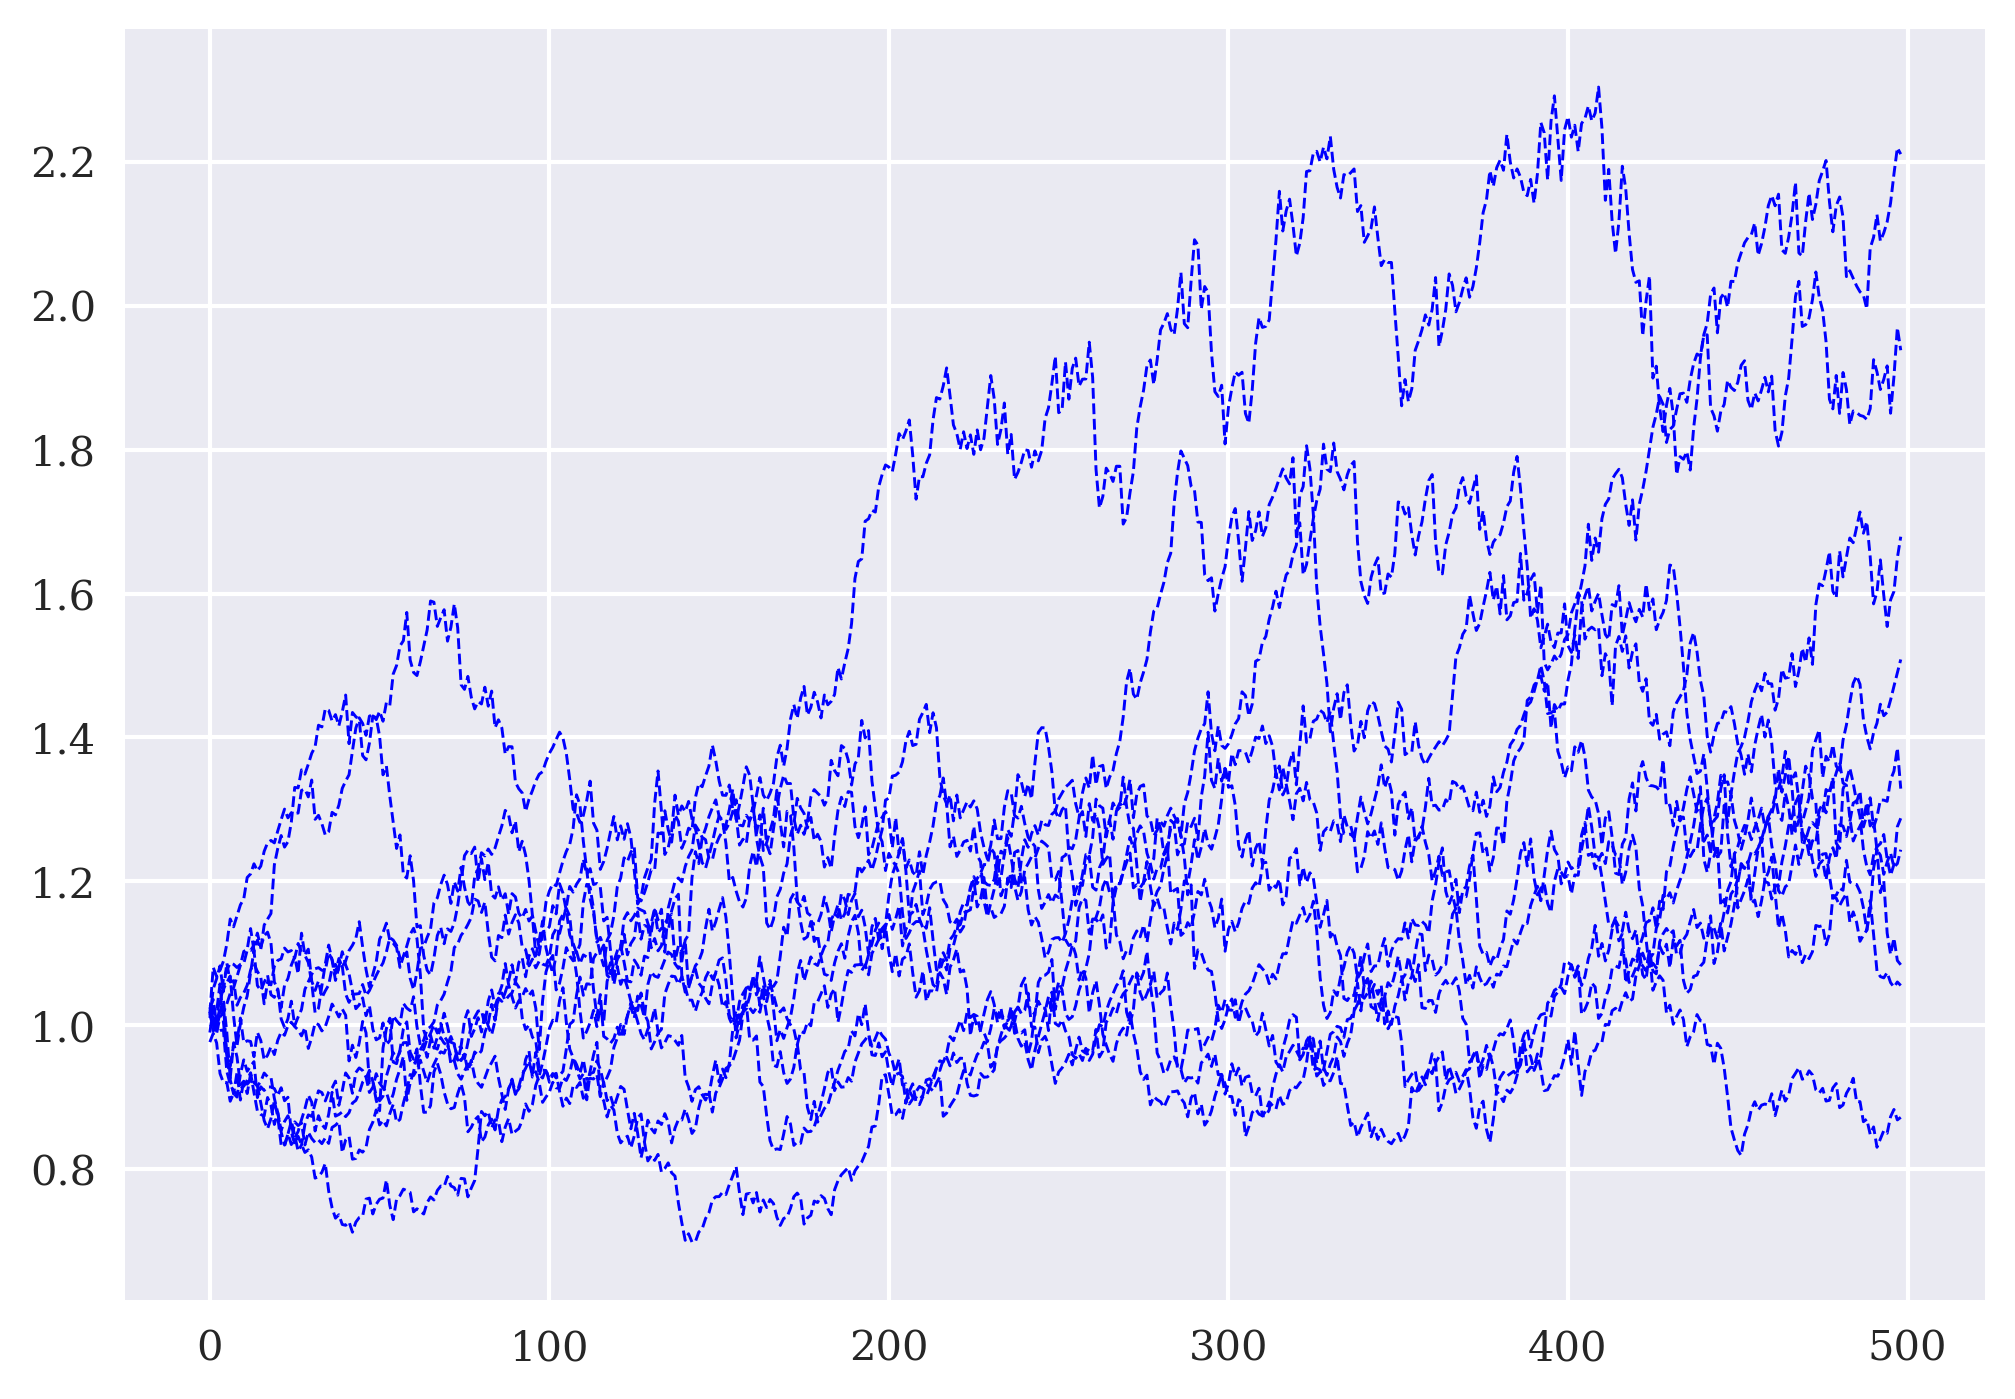

In [55]:
future.iloc[:int(len(data) / 2)].cumsum().apply(np.exp).plot(
    style='b--', lw=0.7, legend=False);

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>